In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import shutil
import zipfile

import cv2
from PIL import Image

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.applications import vgg19, resnet50
from tensorflow.keras.callbacks import Callback, EarlyStopping, TerminateOnNaN, CSVLogger
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, Activation, GlobalAveragePooling2D, BatchNormalization, InputLayer
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

D:\Programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Marine Vessel Classification

## Abstract

The aim of this paper is to create a ship classifier which,  when fed images, could distinguish between several categories of marine vessels. Two distinct approaches will be used and compared -  a neural network from scratch and using an established architecture via transfer learning.

## 1. Introduction

There is a vast number of marine vessel types globally. Ships are built with one purpose in mind, then retrofitted with new gear as plans for them change. Other ships are meant to be multipurpose from the design stage. Nevertheless, some categories have long been established and most vessels are built with a specific task in mind. No professional in the marine industry would fail to distinguish between a container ship and a tanker, for example.

The varying purposes lead to differing optimizations when it comes to ship design. Without getting into details as to the reasons behind these differences: most cargo ships have their superstructure (simply put, the part of the ship sticking above the main deck) in the aft or midship areas of the vessel, while supply ships usually have a forward-placed superstructure. Passenger ships, on the other hand, have superstructures stretching almost the full length of the ship to acommodate all the passengers and various restaurants and theatres.

It is differences such as this that aid humans in distinguishing vessels. With the development of modern computer vision, there is no reason to believe that a deep neural network cannot learn to detect these features as well.

## 2. Ships Dataset Choice and Data Preprocessing
  
In this section, we begin by discussing the dataset chosen for the task and how data acquisition was accomplished. Next, the preprocessing and data augmentation techniques used will be described. 

### 2.1 Ships Image Dataset

Unfortunately, as of the time of writing, there exists little choice when it comes to large, labelled, publicly available datasets of marine vessel images. The only collection of sufficient size for the successful application of deep learning techniques is the MARVEL (Marine Vessel) Dataset [1], with over 200,000 images. Gundogdu E. et al, the authors of the dataset, have kindly provided a Python script for downloading MARVEL from shipspotting.com, which is a website full of information regarding a large amount of marine vessels. However, due to the naturally slow speed of the data acquisition process (essentially downloading each image one by one, albeit using multithreading), in addition to hardware and time contraints involved in downloading the full dataset and working with it, it was decided to use a subset of the data and leave out some of the ship classes. As a comparison, Leclerc M. et al [2] worked on the full MARVEL  and, after some careful class unifications (where applicable) to create a smaller and slightly broader sample of ship classes, came up with 26 distinct vessel types. The models in this paper will work with 17 out of these 26 vessel types.

### 2.2 Data Preprocessing and Augmentation

On the coding side, Python will be used as a programming language, with Tensorflow the library of choice and, more specifically, its Keras API. The built-in classes and methods for data preprocessing and augmentation will be used. As discussed in Section 3, I will first implement a multilayered convolutional neural network from scratch, then build a new model using an established architecture, such as Resnet50 by simply changing the output layers to match the current problem (also known as transfer learning). As Resnet50 was trained on images of size 224x224x3, all images will be reshaped to match its input. Therefore, the initial architecture will be built with the same initial layer size in mind.

In [2]:
# some file paths used
PATH = 'Datasets/Ships/'
TRAIN_PATH = PATH + 'train/'
VALID_PATH = PATH + 'valid/'
TEST_PATH = PATH + 'test/'

In [0]:
# chosen image size and batch size to be used for all architectures
img_size = 224
batch_size = 64

To give the model more data to work with and generalize better,  Keras' data augmentation class ImageDataGenerator was used to shift, shear, flip and rotate the images:

In [53]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 30,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range  = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest',
        data_format = 'channels_last')

test_datagen = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last')

train_generator = train_datagen.flow_from_directory(
                    directory = TRAIN_PATH,
                    target_size = (img_size, img_size),
                    batch_size = batch_size,
                    class_mode = 'categorical',
                    shuffle = True,
                    seed = 42)

valid_generator = test_datagen.flow_from_directory(
                    directory = VALID_PATH,
                    target_size = (img_size, img_size),
                    batch_size = batch_size,
                    class_mode = 'categorical',
                    shuffle = False)

test_generator = test_datagen.flow_from_directory(
                    directory = TEST_PATH,
                    target_size = (img_size, img_size),
                    batch_size = 1,
                    class_mode = 'categorical',
                    shuffle = False)

Found 30163 images belonging to 17 classes.
Found 7559 images belonging to 17 classes.
Found 7983 images belonging to 1 classes.


In addition to the images, the Python script  [1] can optionally download ***.dat *** files containing information for each ship. It is these files that were used to determine the classes. To make working with this information easier, it was formatted and added to a Pandas DataFrame, which was then used to create a *** .csv *** file. Many columns containing information irrelevant to image classification were retained in the ***.csv *** files. This was done with future research in mind. The methods used are shown below:

In [0]:
def extract_features(lines, img_name):
# Cleans ship data and puts it into a single format, ready to be used as a dataframe
  columns = {
    'img_name',
    'title',
    'imo',
    'description',
    'name',
    'vessel_type',
    'gross_tonnage',
    'summer_dwt',
    'year_built',
    'home_port',
    'class_society',
    'flag',
    'call_sign',
    'mmsi',
    'length',
    'beam',
    'draught'
  }

    features = {line[0].lower().replace(' ', '_'): line[1] for line in lines}

    if 'photographer' in features:
        features['photographer'] = features['photographer'].replace(' [View profile]', '')

    if 'gross_tonnage' in features:
        features['gross_tonnage'] = int(features['gross_tonnage'].replace(' tons', '').replace(',', ''))
    if 'summer_dwt' in features:
        features['summer_dwt'] = int(features['summer_dwt'].replace(' tons', '').replace(',', ''))
    if 'length' in features: 
        features['length'] = float(re.compile('\d{1,3}[.,]?\d{0,2}').search(features['length']).group(0).replace(',', '.'))
    if 'beam' in features:
        features['beam'] = float(re.compile('\d{1,3}[.,]?\d{0,2}').search(features['beam']).group(0).replace(',', '.'))
    if 'draught' in features:
        features['draught'] = float(re.compile('\d{1,3}[.,]?\d{0,2}').search(features['draught']).group(0).replace(',', '.'))  
    if 'callsign' in features:
        features['call_sign'] = features['callsign']
    if 'build_year' in features:
        features['year_built'] = features['build_year']

    features['img_name'] = img_name

    features = {k: v for k, v in features.items() if k in columns}
    # some .dat files don't contain all columns, so add NaN in this case
    for column in columns:
        if column not in features:
            features[column] = np.NaN

    return features

In [0]:
filenames = next(iter(os.walk(PATH)))[2]

# collect information form .dat files
ships = [sorted(columns)]
for filename in filenames:
    extension = filename[-3:]
    name = filename[:-4]
    
    if extension == 'dat':
        try:
            items = [line.rstrip().split(': ') for line in open(PATH + filename, 'r', encoding = 'utf-8')]
            items = np.array([item for item in items if len(item) > 1])
        except:
            print(items)
            print(filename)
            break
        features = extract_features(items, name + '.jpg')
        ship = [feature[1] for feature in sorted(features.items())]
        ships.append(ship)
  
# write to csv
with open('ships.csv', 'w', encoding = 'utf-8') as fd:
    wr = csv.writer(fd)
    wr.writerows(ships)

It should also be noted that the data was split into training, validation and test sets, with the test set consisting of a random 20% of data for each class, and the validation set amounting to 20% of the data left when the test set was taken into account (again, the percentage was taken for each class to ensure all possible outcomes are represented in the test and validation sets). The remaining data formed the training set.

## 3. Deep Learning Methods Used
As mentioned earlier, two distinct approaches were tested - first, a neural network was developed from scratch. Then, a transfer learning solution was used, using the popular Resnet50 architecture as a basis, to try and improve on the results.

### 3.1 CNN Architecture from Scratch
As is standard nowadays for any problem related to computer vision, the general structure used was a series of convolutional layers to capture the image features, followed by dense layers to combine them and make the classification decision. The initial model is given below.
 The loss function and metric of success are well established for this kind of problem - respectively, cross-entropy loss and accuracy score.

In [0]:
model = Sequential([
    InputLayer(input_shape = (img_size, img_size, 3)),
    Conv2D(64, kernel_size = 5, strides = 1, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, kernel_size = 7, strides = 3, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Conv2D(128, kernel_size = 5, strides = 1, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, kernel_size = 5, strides = 2, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Conv2D(128, kernel_size = 5, strides = 2, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Conv2D(256, kernel_size = 5, strides = 1, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, kernel_size = 5, strides = 2, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    GlobalAveragePooling2D('channels_last'),
    Flatten(),
    Dense(256),
    Activation('relu'),
    Dropout(0.5),
    Dense(17),
    Activation('softmax')
])

In [58]:
optimizer = Adam(lr = 0.001)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy',metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 224, 224, 64)      4864      
_________________________________________________________________
batch_normalization_7 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
activation_9 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 75, 75, 64)        200768    
_________________________________________________________________
batch_normalization_8 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
activation_10 (Activation)   (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 64)        0         
__________

When training neural networks, a criterion is needed to determine whether the model is under/overfitting, or if it even starts to generalize at all. A good method to use is to compare the training loss and the validation loss. If both are not decreasing, the model has done what it can in training and if the values are close, it at least does a good job of generalizing. This could, however, be due to underfitting and means a more complex model can be examined.

If the validation loss plateaus, while the training loss keeps going further away from it, then the model is probably overfitting. Perhaps the model is too sophisticated for the amount of data available. In this case, gathering additional data or adding regularization to the model could fix this issue.

Bearing these considerations in mind, an early stopping technique was used to stop model training in case the validation loss did not improve in a certain number of epochs, as can be seen in the code below.

Since the first architecture was initially trained, its weights saved and then removed from the notebook, it has been loaded again for the purposes of describing the model development process. After loading the weights, the model was trained for an additional three epochs in order to show the training/validation loss/accuracy values it has reached. This is why such high accuracies/low losses can be seen from the very first epoch. Please also note that early stopping was omitted for the initial model since it was pretrained.

In [0]:
step_size_train = train_generator.n // train_generator.batch_size
step_size_valid = valid_generator.n // valid_generator.batch_size
callback = [TerminateOnNaN()]

In [68]:
model.fit_generator(generator = train_generator,
                    steps_per_epoch = step_size_train,
                    epochs = 3, 
                    callbacks = callback,
                    validation_data = valid_generator,
                    validation_steps = step_size_valid,
                    workers = 4)

Epoch 1/3
479/479 [==============================] - 462s 965ms/step - loss: 0.8688 - acc: 0.7340 - val_loss: 0.8341 - val_acc: 0.7396
Epoch 2/3
479/479 [==============================] - 461s 962ms/step - loss: 0.8642 - acc: 0.7321 - val_loss: 0.8454 - val_acc: 0.7386
Epoch 3/3
479/479 [==============================] - 461s 963ms/step - loss: 0.8625 - acc: 0.7358 - val_loss: 0.8538 - val_acc: 0.7336


With validation and training losses both showing signs of saturation, I suspected potential underfitting. Perhaps increasing the complexity of the model could lead to improvements. The first adjustment attempted was to increase the size of the fully-connected layer from 256 to 512 units.

In [0]:
model = Sequential(layers = [
    InputLayer(input_shape = (img_size, img_size, 3)),
    Conv2D(64, kernel_size = 7, strides = 3, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, kernel_size = 5, strides = 1, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Conv2D(128, kernel_size = 5, strides = 1, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, kernel_size = 5, strides = 1, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Conv2D(128, kernel_size = 5, strides = 2, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Conv2D(256, kernel_size = 5, strides = 1, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, kernel_size = 5, strides = 2, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),
    GlobalAveragePooling2D('channels_last'),
    Flatten(),
    Dense(512),
    Activation('relu'),
    Dropout(0.5),
    Dense(17),
    Activation('softmax')
])

In [0]:
optimizer = Adam(lr = 0.01)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy',metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 75, 75, 64)        9472      
_________________________________________________________________
batch_normalization_8 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
activation_10 (Activation)   (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 75, 75, 64)        102464    
_________________________________________________________________
batch_normalization_9 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
activation_11 (Activation)   (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 64)        0         
__________

In [0]:
callback = [EarlyStopping(min_delta = 0.01, patience = 4),
            TerminateOnNaN()]

model.fit_generator(generator = train_generator,
                    steps_per_epoch = step_size_train,
                    epochs = 20, 
                    callbacks = callback,
                    validation_data = valid_generator,
                    validation_steps = step_size_valid,
                    workers = 4)

Epoch 1/20
479/479 [==============================] - 427s 892ms/step - loss: 2.7156 - acc: 0.1454 - val_loss: 2.5663 - val_acc: 0.1607
Epoch 2/20
479/479 [==============================] - 409s 854ms/step - loss: 2.5311 - acc: 0.1707 - val_loss: 2.4759 - val_acc: 0.2072
Epoch 3/20
479/479 [==============================] - 431s 899ms/step - loss: 2.4026 - acc: 0.2247 - val_loss: 2.8002 - val_acc: 0.1475
Epoch 4/20
479/479 [==============================] - 415s 866ms/step - loss: 2.3164 - acc: 0.2556 - val_loss: 2.4624 - val_acc: 0.2264
Epoch 5/20
479/479 [==============================] - 416s 869ms/step - loss: 2.1762 - acc: 0.3205 - val_loss: 2.0146 - val_acc: 0.3725
Epoch 6/20
479/479 [==============================] - 419s 874ms/step - loss: 1.9664 - acc: 0.3885 - val_loss: 1.9293 - val_acc: 0.3825
Epoch 7/20
479/479 [==============================] - 420s 876ms/step - loss: 1.8239 - acc: 0.4295 - val_loss: 2.1237 - val_acc: 0.3791
Epoch 8/20
479/479 [============================

After training for 20 epochs, it seemed that the model still had room for improvement, if given more time. Therefore, I continued training for a further 20 epochs

In [0]:
model.fit_generator(generator = train_generator,
                    steps_per_epoch = step_size_train,
                    epochs = 20, 
                    callbacks = callback,
                    validation_data = valid_generator,
                    validation_steps = step_size_valid,
                    workers = 4)

Epoch 1/20
479/479 [==============================] - 412s 860ms/step - loss: 1.1622 - acc: 0.6467 - val_loss: 1.5221 - val_acc: 0.5830
Epoch 2/20
479/479 [==============================] - 412s 859ms/step - loss: 1.1536 - acc: 0.6507 - val_loss: 1.6149 - val_acc: 0.5102
Epoch 3/20
479/479 [==============================] - 410s 857ms/step - loss: 1.1347 - acc: 0.6592 - val_loss: 1.1144 - val_acc: 0.6555
Epoch 4/20
479/479 [==============================] - 411s 858ms/step - loss: 1.1106 - acc: 0.6663 - val_loss: 1.3543 - val_acc: 0.5773
Epoch 5/20
479/479 [==============================] - 411s 857ms/step - loss: 1.0944 - acc: 0.6699 - val_loss: 1.1799 - val_acc: 0.6514
Epoch 6/20
479/479 [==============================] - 410s 855ms/step - loss: 1.0769 - acc: 0.6767 - val_loss: 1.2405 - val_acc: 0.6267
Epoch 7/20
479/479 [==============================] - 410s 856ms/step - loss: 1.0698 - acc: 0.6754 - val_loss: 1.0365 - val_acc: 0.6880
Epoch 8/20
479/479 [============================

Early stopping halted the training process after 11 epochs as the validation loss was not improving. Increasing the fully-connected layer size didn't seem to improve the model (in fact, it seemed to make it worse).

Further changes were made to the model. Most importantly, an additional convolution layer was added.

In [0]:
model_dlr = Sequential(layers = [
    InputLayer(input_shape = (img_size, img_size, 3)),
    Conv2D(64, kernel_size = 7, strides = 3, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, kernel_size = 5, strides = 1, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Conv2D(128, kernel_size = 5, strides = 1, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, kernel_size = 5, strides = 1, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Conv2D(128, kernel_size = 5, strides = 2, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Conv2D(256, kernel_size = 5, strides = 1, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, kernel_size = 5, strides = 1, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, kernel_size = 5, strides = 2, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),
    GlobalAveragePooling2D('channels_last'),
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(17),
    Activation('softmax')
])

Another change was introduced due to observations made during training of the previous model instances. Training loss would decrease at the start of an epoch, then slowly start to climb back up. I interpreted this as a sign of the learning rate being too high. A value of 0.01 seemed to work well for the initial epochs, but the model appeared to struggle in the latter training stages.  For this reason, I decided to introduce learning rate decay.

In [0]:
epochs = 30
lr = 0.01
optimizer = Adam(lr = lr, decay = lr / epochs)
model_dlr.compile(optimizer = optimizer, loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [0]:
model_dlr.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 75, 75, 64)        9472      
_________________________________________________________________
batch_normalization_27 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
activation_30 (Activation)   (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 75, 75, 64)        102464    
_________________________________________________________________
batch_normalization_28 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
activation_31 (Activation)   (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 37, 37, 64)        0         
__________

In [0]:
model_dlr.fit_generator(generator = train_generator,
                    steps_per_epoch = step_size_train,
                    epochs = epochs, 
                    callbacks = callback,
                    validation_data = valid_generator,
                    validation_steps = step_size_valid,

                        workers = 6)

Epoch 1/30
479/479 [==============================] - 396s 826ms/step - loss: 2.8375 - acc: 0.1469 - val_loss: 3.1621 - val_acc: 0.0772
Epoch 2/30
479/479 [==============================] - 389s 813ms/step - loss: 2.3632 - acc: 0.2508 - val_loss: 2.5572 - val_acc: 0.2039
Epoch 3/30
479/479 [==============================] - 389s 811ms/step - loss: 1.9971 - acc: 0.3650 - val_loss: 2.0357 - val_acc: 0.3747
Epoch 4/30
479/479 [==============================] - 390s 815ms/step - loss: 1.7541 - acc: 0.4464 - val_loss: 2.4605 - val_acc: 0.3310
Epoch 5/30
479/479 [==============================] - 395s 824ms/step - loss: 1.5959 - acc: 0.4972 - val_loss: 2.1421 - val_acc: 0.4132
Epoch 6/30
479/479 [==============================] - 395s 825ms/step - loss: 1.4767 - acc: 0.5397 - val_loss: 1.5999 - val_acc: 0.5000
Epoch 7/30
479/479 [==============================] - 393s 820ms/step - loss: 1.3793 - acc: 0.5738 - val_loss: 1.4838 - val_acc: 0.5429
Epoch 8/30
479/479 [============================

The additional convolution layer, perhaps in addition to learning rate decay, resulted in an obvious improvement in validation accuracy. However, since the training loss was still decreasing when early stopping intervened, I wanted to give this model a few more epochs to train.

In [0]:
model_dlr.fit_generator(generator = train_generator,
                    steps_per_epoch = step_size_train,
                    epochs = 10, 
                    callbacks = callback,
                    validation_data = valid_generator,
                    validation_steps = step_size_valid,

                        workers = 6)

Epoch 1/10
479/479 [==============================] - 404s 843ms/step - loss: 0.5460 - acc: 0.8275 - val_loss: 0.7116 - val_acc: 0.7870
Epoch 2/10
479/479 [==============================] - 401s 838ms/step - loss: 0.5305 - acc: 0.8318 - val_loss: 0.6697 - val_acc: 0.7991
Epoch 3/10
479/479 [==============================] - 401s 837ms/step - loss: 0.5175 - acc: 0.8355 - val_loss: 0.6583 - val_acc: 0.8027
Epoch 4/10
479/479 [==============================] - 401s 838ms/step - loss: 0.4995 - acc: 0.8441 - val_loss: 0.6635 - val_acc: 0.8055
Epoch 5/10
479/479 [==============================] - 402s 839ms/step - loss: 0.4883 - acc: 0.8459 - val_loss: 0.6896 - val_acc: 0.8034
Epoch 6/10
479/479 [==============================] - 403s 842ms/step - loss: 0.4782 - acc: 0.8493 - val_loss: 0.6702 - val_acc: 0.8036
Epoch 7/10
479/479 [==============================] - 403s 840ms/step - loss: 0.4582 - acc: 0.8540 - val_loss: 0.6563 - val_acc: 0.8164


Validation loss and accuracy managed to improve further, raising the bar on the previous architecture. Additional model complexity seemed to be beneficial. Despite signs of overfitting already starting to show (consistent gap between training and validation loss), I suspected some additional layers could yet squeeze out some performance out of the available data. Both convolution and dense layers were added for the latest architecture.

In [0]:
model_decr = Sequential(layers = [
    InputLayer(input_shape = (img_size, img_size, 3)),
    Conv2D(64, kernel_size = 7, strides = 2, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, kernel_size = 5, strides = 1, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Conv2D(128, kernel_size = 5, strides = 1, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, kernel_size = 5, strides = 1, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Conv2D(128, kernel_size = 5, strides = 2, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Conv2D(256, kernel_size = 5, strides = 1, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Conv2D(256, kernel_size = 3, strides = 1, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, kernel_size = 3, strides = 1, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Conv2D(512, kernel_size = 3, strides = 1, padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    GlobalAveragePooling2D('channels_last'),
    Flatten(),
    Dense(1024),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(17),
    Activation('softmax')
])

In [0]:
epochs = 40
lr = 0.01
optimizer = Adam(lr = lr, decay = lr / epochs)
model_decr.compile(optimizer = optimizer, loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [0]:
model_decr.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_10 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_11 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 64)      102464    
_________________________________________________________________
batch_normalization_11 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_12 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
__________

In [0]:
model_decr.fit_generator(generator = train_generator,
                    steps_per_epoch = step_size_train,
                    epochs = epochs, 
                    callbacks = callback,
                    validation_data = valid_generator,
                    validation_steps = step_size_valid,
                        workers = 6)

Epoch 1/40
479/479 [==============================] - 424s 886ms/step - loss: 2.8104 - acc: 0.1441 - val_loss: 2.5762 - val_acc: 0.1689
Epoch 2/40
479/479 [==============================] - 417s 871ms/step - loss: 2.5432 - acc: 0.1839 - val_loss: 2.7287 - val_acc: 0.1580
Epoch 3/40
479/479 [==============================] - 418s 872ms/step - loss: 2.2430 - acc: 0.2814 - val_loss: 2.4270 - val_acc: 0.2337
Epoch 4/40
479/479 [==============================] - 422s 881ms/step - loss: 1.9699 - acc: 0.3722 - val_loss: 1.9724 - val_acc: 0.3934
Epoch 5/40
479/479 [==============================] - 416s 868ms/step - loss: 1.7657 - acc: 0.4439 - val_loss: 2.6990 - val_acc: 0.2283
Epoch 6/40
479/479 [==============================] - 410s 856ms/step - loss: 1.5979 - acc: 0.5038 - val_loss: 1.6755 - val_acc: 0.4765
Epoch 7/40
479/479 [==============================] - 415s 866ms/step - loss: 1.4793 - acc: 0.5443 - val_loss: 3.1435 - val_acc: 0.2285
Epoch 8/40
479/479 [============================

Disappointingly, after training was halted on the 34-th epoch, validation metrics were no better than the equivalent in the simpler model. Nevertheless, to be an impartial judge, I decided to give this model a second run, as I had done so for its predecessors.

In [0]:
epochs = 10
lr = 0.001
optimizer = Adam(lr = lr, decay = lr / epochs)
model_decr.compile(optimizer = optimizer, loss = 'categorical_crossentropy',metrics = ['accuracy'])

model_decr.fit_generator(generator = train_generator,
                    steps_per_epoch = step_size_train,
                    epochs = epochs, 
                    callbacks = callback,
                    validation_data = valid_generator,
                    validation_steps = step_size_valid,
                        workers = 8)

Epoch 1/10
479/479 [==============================] - 414s 864ms/step - loss: 0.5053 - acc: 0.8423 - val_loss: 0.6652 - val_acc: 0.8034
Epoch 2/10
479/479 [==============================] - 409s 854ms/step - loss: 0.4804 - acc: 0.8502 - val_loss: 0.6629 - val_acc: 0.8063
Epoch 3/10
479/479 [==============================] - 410s 856ms/step - loss: 0.4652 - acc: 0.8550 - val_loss: 0.6970 - val_acc: 0.8004
Epoch 4/10
479/479 [==============================] - 412s 860ms/step - loss: 0.4519 - acc: 0.8570 - val_loss: 0.6795 - val_acc: 0.8069
Epoch 5/10
479/479 [==============================] - 412s 861ms/step - loss: 0.4495 - acc: 0.8604 - val_loss: 0.6674 - val_acc: 0.8051


The best this latest model could manage before early stopping intervened again, was to close in on the metrics of its predecessor. Additional model complexity didn't seem to lead to further improvements. It seemed like improving the results could only be done by gathering more data. Nevertheless, I wanted to take model depth to the extreme and try transfer learning.


### 3.2 Transfer Learning
The model chosen for the task was the well-known Resnet50 architecture. The output layers were omitted and custom dense layers were added to match the output to the required number of classes

In [15]:
model_resnet = resnet50.ResNet50(include_top = False)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 2s 0us/step


In [0]:
x = model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
preds = Dense(17,activation='softmax')(x)

Initially, all the original Resnet layers were frozen, with only the added dense layers left trainable:

In [0]:
model_resnet = Model(inputs = model_resnet.input,outputs = preds)

for layer in model_resnet.layers[:-10]:
    layer.trainable = False
for layer in model_resnet.layers[-10:]:
    layer.trainable = True

In [0]:
model_resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

For the purposes of transfer learning, the data generators had to be modified to use the Resnet50 input preprocessing function

In [0]:
train_datagen_res = ImageDataGenerator(
        rotation_range = 30,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range  = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest',
        data_format = 'channels_last',
        preprocessing_function = resnet50.preprocess_input)

test_datagen_res = ImageDataGenerator(data_format = 'channels_last',
                                      preprocessing_function = resnet50.preprocess_input)

train_generator_res = train_datagen_res.flow_from_directory(
                    directory = TRAIN_PATH,
                    batch_size = batch_size,
                    class_mode = 'categorical',
                    shuffle = True,
                    seed = 42)

valid_generator_res = test_datagen_res.flow_from_directory(
                    directory = VALID_PATH,
                    batch_size = batch_size,
                    class_mode = 'categorical',
                    shuffle = False)

test_generator_res = test_datagen_res.flow_from_directory(
                    directory = TEST_PATH,
                    target_size = (img_size, img_size),
                    batch_size = 1,
                    class_mode = 'categorical',
                    shuffle = False)

Found 30669 images belonging to 17 classes.
Found 7657 images belonging to 17 classes.
Found 8044 images belonging to 1 classes.


The dense layers were only trained for 5 epochs on their own. This was done in order to give their weights some initial, non-random state as otherwise their values could throw off the convolution layers further back in the initial epochs and slow training down. 

In [0]:
epochs = 5
lr = 0.01
optimizer = Adam(lr = lr, decay = lr / epochs)
model_resnet.compile(optimizer = optimizer, loss = 'categorical_crossentropy',metrics = ['accuracy'])

model_resnet.fit_generator(generator = train_generator_res,
                    steps_per_epoch = step_size_train,
                    epochs = epochs, 
                    callbacks = callback,
                    validation_data = valid_generator_res,
                    validation_steps = step_size_valid,
                        workers = 8)

Epoch 1/5
479/479 [==============================] - 554s 1s/step - loss: 1.2567 - acc: 0.6120 - val_loss: 1.2526 - val_acc: 0.6050
Epoch 2/5
479/479 [==============================] - 553s 1s/step - loss: 1.0993 - acc: 0.6564 - val_loss: 1.4726 - val_acc: 0.5558
Epoch 3/5
479/479 [==============================] - 553s 1s/step - loss: 1.0251 - acc: 0.6744 - val_loss: 1.2672 - val_acc: 0.5989
Epoch 4/5
479/479 [==============================] - 555s 1s/step - loss: 0.9790 - acc: 0.6920 - val_loss: 1.1977 - val_acc: 0.6141
Epoch 5/5
479/479 [==============================] - 555s 1s/step - loss: 0.9491 - acc: 0.6992 - val_loss: 1.2904 - val_acc: 0.5928


The last two convolutional layers were then also unfreezed so they could adjust to the task of ship classification.

In [0]:
for layer in model_resnet.layers[-17:]:
    layer.trainable = True

In [0]:
epochs = 20
lr = 0.01
optimizer = Adam(lr = lr, decay = lr / epochs)
model_resnet.compile(optimizer = optimizer, loss = 'categorical_crossentropy',metrics = ['accuracy'])

model_resnet.fit_generator(generator = train_generator_res,
                    steps_per_epoch = step_size_train,
                    epochs = epochs, 
                    callbacks = callback,
                    validation_data = valid_generator_res,
                    validation_steps = step_size_valid,
                        workers = 8)

Epoch 1/20
479/479 [==============================] - 563s 1s/step - loss: 1.0770 - acc: 0.6652 - val_loss: 1.4241 - val_acc: 0.5889
Epoch 2/20
479/479 [==============================] - 562s 1s/step - loss: 0.9088 - acc: 0.7106 - val_loss: 1.0755 - val_acc: 0.6665
Epoch 3/20
479/479 [==============================] - 560s 1s/step - loss: 0.8338 - acc: 0.7348 - val_loss: 1.2182 - val_acc: 0.6299
Epoch 4/20
479/479 [==============================] - 559s 1s/step - loss: 0.7686 - acc: 0.7542 - val_loss: 1.1123 - val_acc: 0.6565
Epoch 5/20
479/479 [==============================] - 563s 1s/step - loss: 0.7179 - acc: 0.7707 - val_loss: 1.0952 - val_acc: 0.6576
Epoch 6/20
479/479 [==============================] - 561s 1s/step - loss: 0.6691 - acc: 0.7826 - val_loss: 1.3556 - val_acc: 0.6195


Unfortunately, early stopping had to intervene again. While the training loss was still improving at a good pace, validation loss seemed to stall and changed almost randomly with each epoch - clear signs of overfitting. It seemed that the amount of data was insufficient when processed through a network as complex as Resnet50.

I decided to look where the model is going wrong and hope for a solution.

## 4. Model Analysis and Data Addition

A good visual representation of where a model is making mistakes is a confusion matrix:

In [0]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def get_predicted(model, generator):
    predicted = model.predict_generator(generator)
    return np.argmax(predicted, axis = 1)

def get_true(test_dir, ships_df):
    filenames = next(iter(os.walk(test_dir)))[2]

    true = []
    for filename in filenames:
    true_str = ships_df[ships_df.img_name == filename]['vessel_type'].values[0]
    true.append(types_dict[true_str])

    return true

In [0]:
ships_df = pd.read_csv(PATH + 'ships_combined_3.csv')

ship_types = sorted(ships_df.vessel_type.unique())
types_dict = {ship_types[i]: i for i in range(len(ship_types))}

predicted = get_predicted(model_decr, test_generator)
true = get_true(TEST_PATH + 'test/', ships_df)

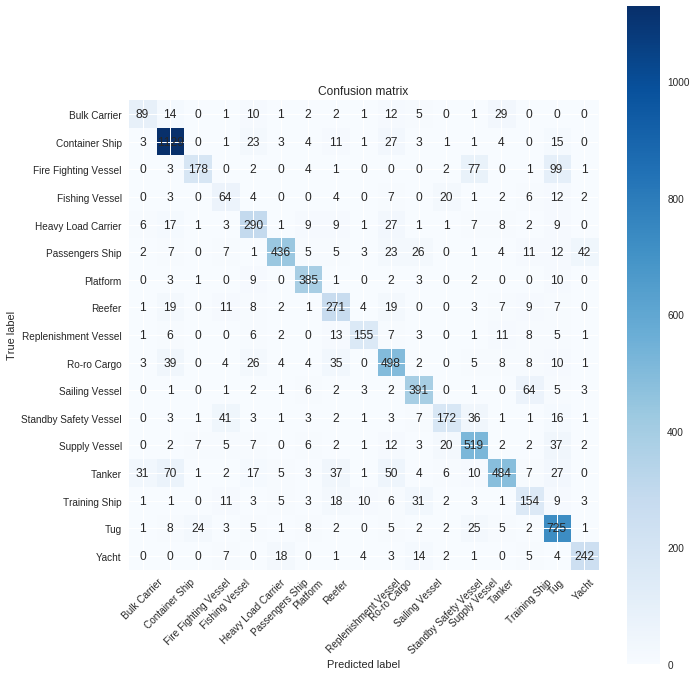

In [0]:
cm = confusion_matrix(true, predicted)
plot_confusion_matrix(cm, ship_types)

While the model seems capable of recognizing most classes with a fair amount of accuracy, a couple of results stand out as particularly low. Firstly, there seem to be a lot of fire fighting vessels misclassified as either standby safety vessels or tugs. Secondly, fishing vessels and bulk carriers have low scores, but are also two of the least represented classes, which could explain their disappointing results.

Regarding the first remark, it is useful to look at a few images of fire fighting, standby safety vessels and tugs to see if there is an obvious reason for the model's confusion (validation set is used here as images in the test set are not labeled):

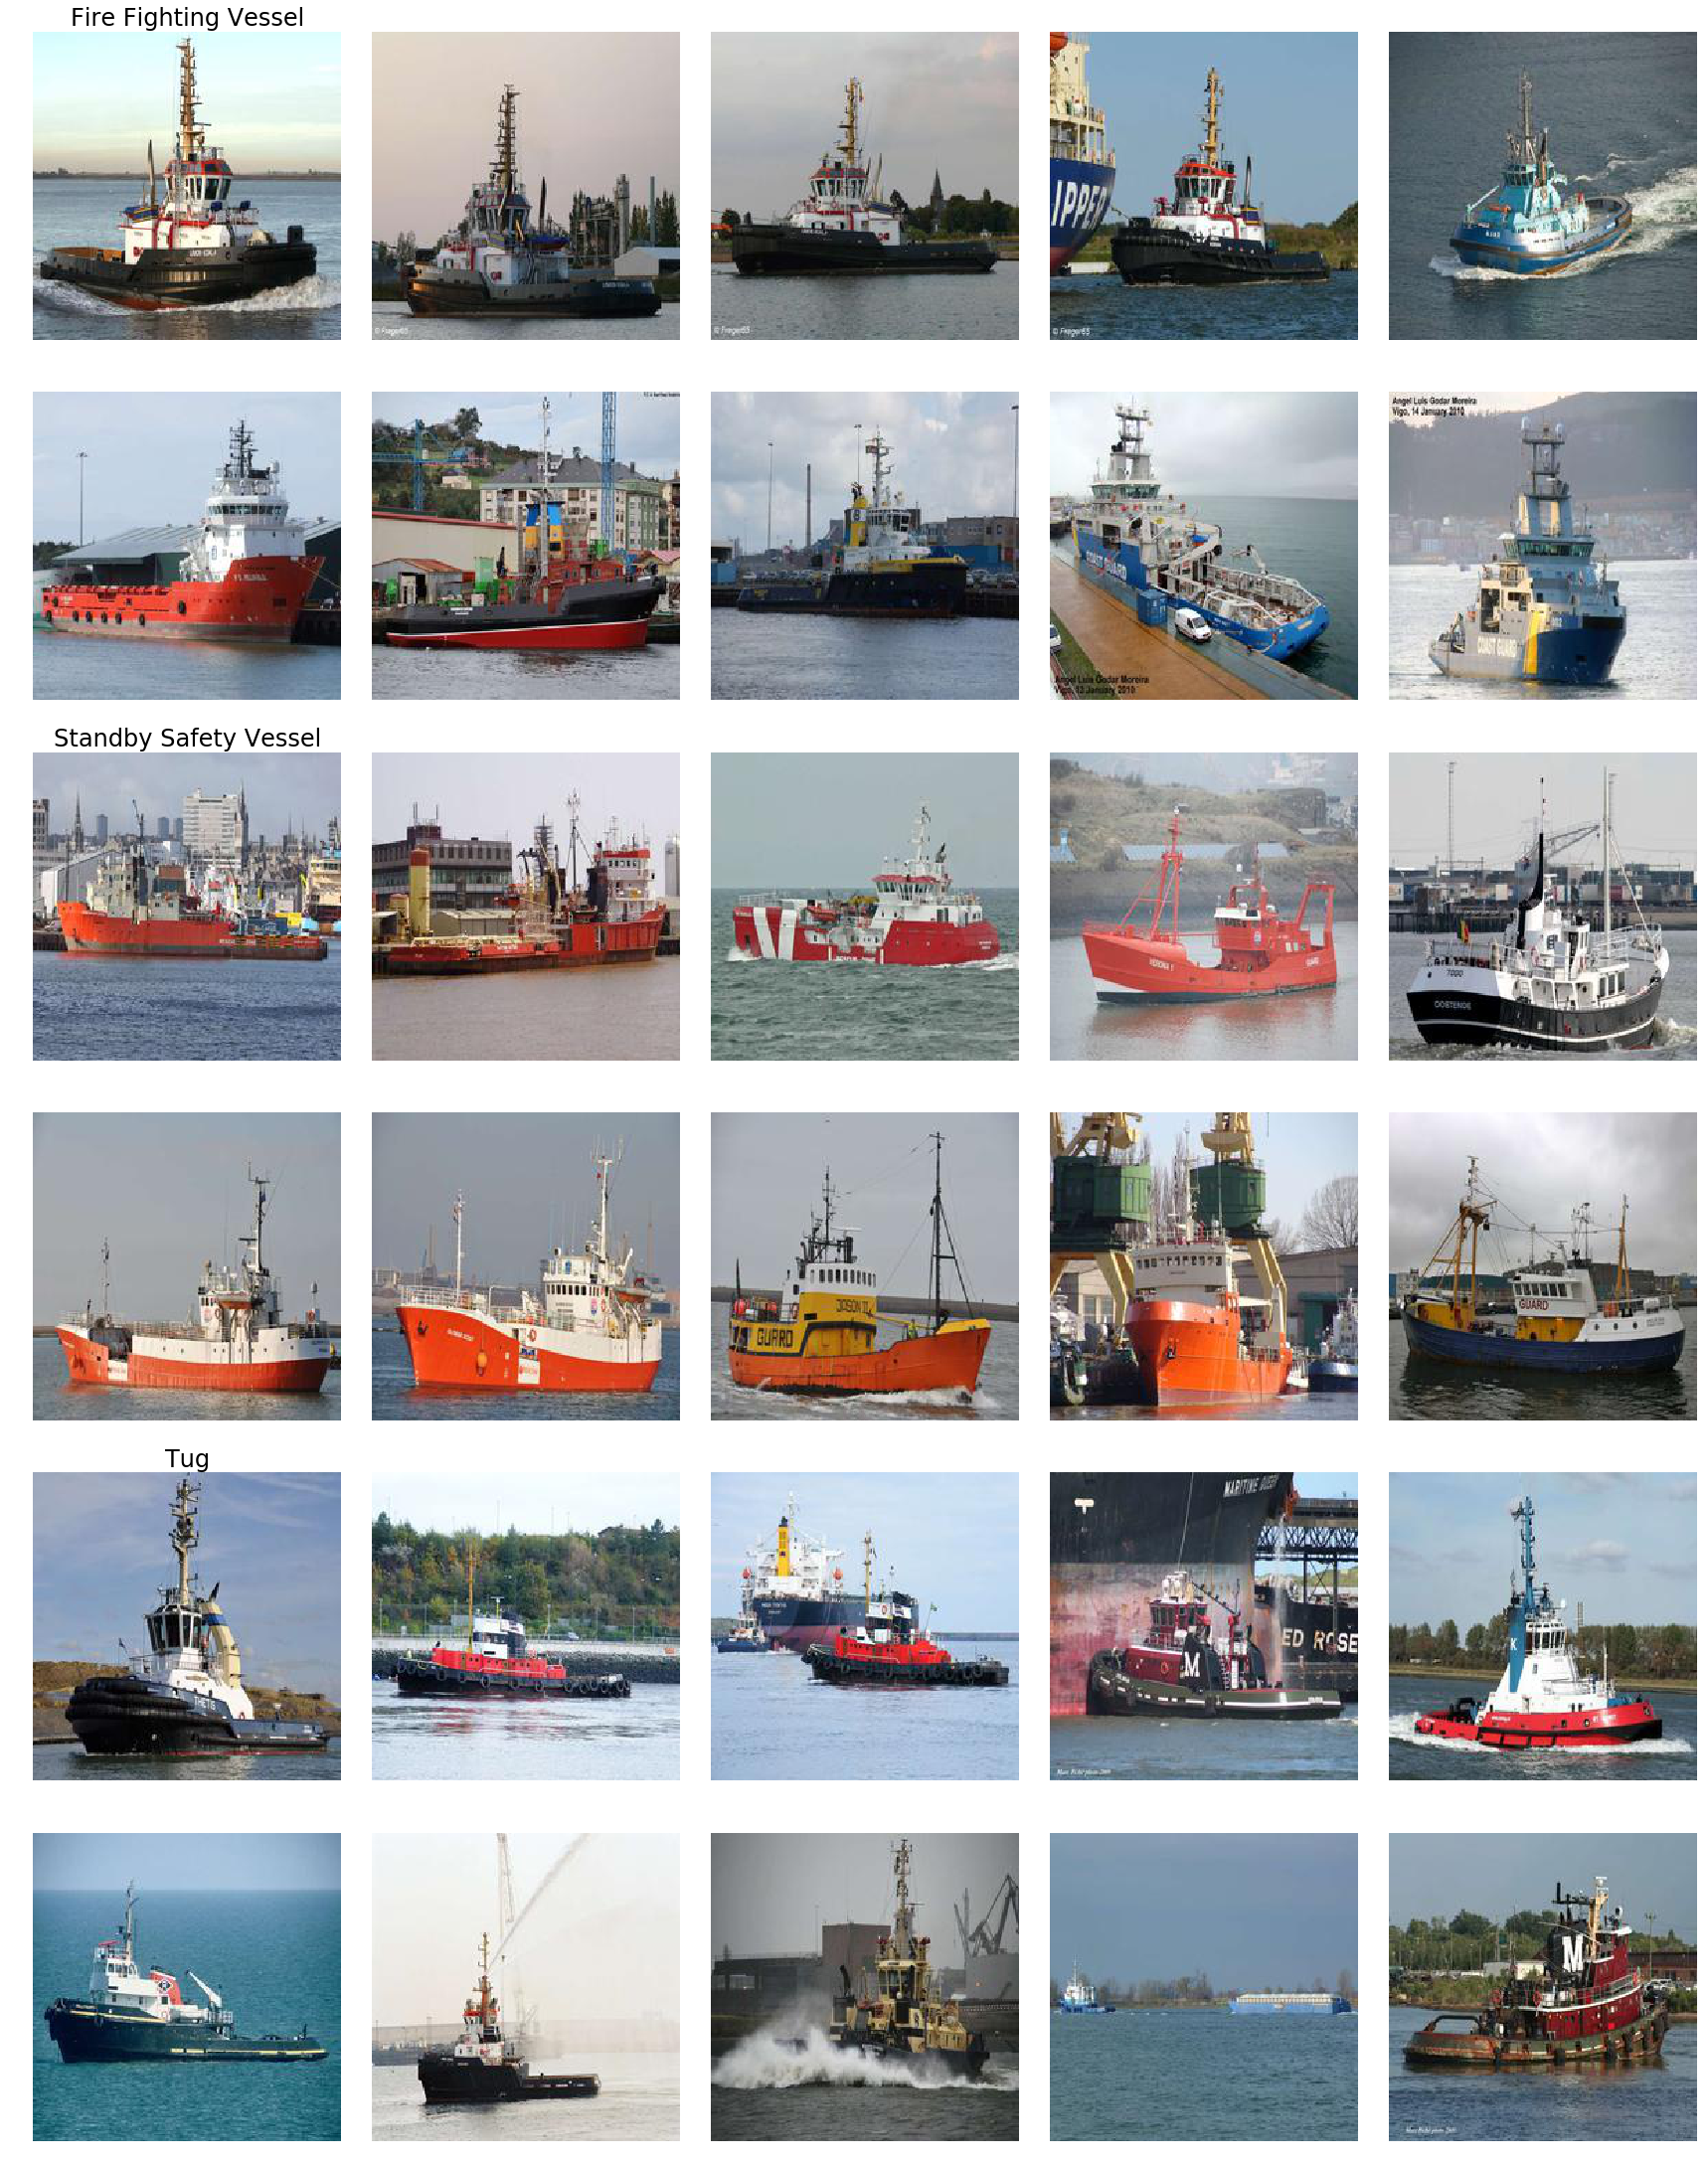

In [4]:
class_folders = ['Fire Fighting Vessel/', 'Standby Safety Vessel/', 'Tug/']

rows_per_class = 2
nrows = len(class_folders) * rows_per_class
ncols = 5

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (30, 40))

for ax, folder in zip(axes[::rows_per_class, 0], class_folders):
    ax.set_title(folder[:-1], rotation = 0, fontsize = 24)

for class_no, folder in enumerate(class_folders):
    class_ = folder[:-1]
    filenames = next(iter(os.walk(VALID_PATH + folder)))[2]
    
    for row in range(rows_per_class):
        for col in range(ncols):
            img = plt.imread(VALID_PATH + folder + filenames[ncols * row + col])
            axes[class_no * rows_per_class + row, col].axis('off')
            axes[class_no * rows_per_class + row, col].imshow(img)

plt.subplots_adjust(wspace = 0.1, hspace = 0)
plt.show()

From the images above it seems arguably a difficult task, even for a human, to differentiate between these classes, possibly with the exception of the safety vessels. 

More generally, the confusion matrix brought one potential issue in light - the data imbalance. Some classes had only a few hundred examples, while others had more than 6,000. The difference in accuracy between the low sample and high sample count classes is made explicit below. The classes are ordered in ascending order based on their number of samples in the test set:

In [0]:
pct_counts = {sum(cm[idx]): (ship_types[idx], cm[idx, idx] / sum(cm[idx])) for idx in range(len(cm))}

for key in sorted(pct_counts.keys()):
    print(f'Percentage of class {pct_counts[key][0]}: {np.round(pct_counts[key][1]*100, 2)}% (out of {key} samples)')

Percentage of class Fishing Vessel: 51.2% (out of 125 samples)
Percentage of class Bulk Carrier: 53.29% (out of 167 samples)
Percentage of class Replenishment Vessel: 70.78% (out of 219 samples)
Percentage of class Training Ship: 59.0% (out of 261 samples)
Percentage of class Standby Safety Vessel: 58.9% (out of 292 samples)
Percentage of class Yacht: 80.4% (out of 301 samples)
Percentage of class Reefer: 74.86% (out of 362 samples)
Percentage of class Fire Fighting Vessel: 48.37% (out of 368 samples)
Percentage of class Heavy Load Carrier: 73.98% (out of 392 samples)
Percentage of class Platform: 92.55% (out of 416 samples)
Percentage of class Sailing Vessel: 81.12% (out of 482 samples)
Percentage of class Passengers Ship: 74.53% (out of 585 samples)
Percentage of class Supply Vessel: 82.78% (out of 627 samples)
Percentage of class Ro-ro Cargo: 76.97% (out of 647 samples)
Percentage of class Tanker: 64.11% (out of 755 samples)
Percentage of class Tug: 88.52% (out of 819 samples)
Perce

A clear trend can be seen, with most classes having accuracy in the 50-60 percent range on the upper side of the list (i.e. having less samples). If any of the models was to improve, more data had to be gathered for those classes.

I altered the script from [1] to preferentially download classes which had less than 80% validation accuracy. The hope was that now the models could learn some features which they were previously unable to notice. The most successful architecture from scratch was first trained to see if there is any improvement. In addition, batch size was doubled from 64 to 128 samples to potentially give a more accurate direction to the gradient descent shifts.

In [13]:
batch_size = 128

# data generators had to be re-run so they could find the new files
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 30,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range  = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest',
        data_format = 'channels_last')

test_datagen = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last')

train_generator = train_datagen.flow_from_directory(
                    directory = TRAIN_PATH,
                    target_size = (img_size, img_size),
                    batch_size = batch_size,
                    class_mode = 'categorical',
                    shuffle = True,
                    seed = 42)

valid_generator = test_datagen.flow_from_directory(
                    directory = VALID_PATH,
                    target_size = (img_size, img_size),
                    batch_size = batch_size,
                    class_mode = 'categorical',
                    shuffle = False)

test_generator = test_datagen.flow_from_directory(
                    directory = TEST_PATH,
                    target_size = (img_size, img_size),
                    batch_size = 1,
                    class_mode = 'categorical',
                    shuffle = False)

Found 57960 images belonging to 17 classes.
Found 12312 images belonging to 17 classes.
Found 13866 images belonging to 1 classes.


In [14]:
epochs = 10
lr = 0.001
optimizer = Adam(lr = lr, decay = lr / epochs)
model_decr.compile(optimizer = optimizer, loss = 'categorical_crossentropy',metrics = ['accuracy'])

step_size_train = train_generator.n // train_generator.batch_size
step_size_valid = valid_generator.n // valid_generator.batch_size
callback = [EarlyStopping(min_delta = 0.01, patience = 4),
            TerminateOnNaN()]
model_decr.fit_generator(generator = train_generator,
                    steps_per_epoch = step_size_train,
                    epochs = epochs, 
                    callbacks = callback,
                    validation_data = valid_generator,
                    validation_steps = step_size_valid,
                        workers = 8)

Epoch 1/10
452/452 [==============================] - 842s 2s/step - loss: 0.6200 - acc: 0.8052 - val_loss: 0.6475 - val_acc: 0.7988
Epoch 2/10
452/452 [==============================] - 832s 2s/step - loss: 0.5991 - acc: 0.8117 - val_loss: 0.6355 - val_acc: 0.7992
Epoch 3/10
452/452 [==============================] - 829s 2s/step - loss: 0.5836 - acc: 0.8180 - val_loss: 0.6191 - val_acc: 0.8022
Epoch 4/10
452/452 [==============================] - 828s 2s/step - loss: 0.5714 - acc: 0.8189 - val_loss: 0.6255 - val_acc: 0.8050
Epoch 5/10
452/452 [==============================] - 826s 2s/step - loss: 0.5603 - acc: 0.8244 - val_loss: 0.6021 - val_acc: 0.8083
Epoch 6/10
452/452 [==============================] - 822s 2s/step - loss: 0.5506 - acc: 0.8263 - val_loss: 0.6037 - val_acc: 0.8114
Epoch 7/10
452/452 [==============================] - 819s 2s/step - loss: 0.5357 - acc: 0.8327 - val_loss: 0.6046 - val_acc: 0.8111
Epoch 8/10
452/452 [==============================] - 823s 2s/step - 

The validation loss has stalled, and the accuracy is close to the original. The additional data doesn't seem to help much. Despite the negative signs, the transfer learning architecture is run on the improved dataset below:

In [18]:
train_datagen_res = ImageDataGenerator(
        rotation_range = 30,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range  = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest',
        data_format = 'channels_last',
        preprocessing_function = resnet50.preprocess_input)

test_datagen_res = ImageDataGenerator(data_format = 'channels_last',
                                      preprocessing_function = resnet50.preprocess_input)

train_generator_res = train_datagen_res.flow_from_directory(
                    directory = TRAIN_PATH,
                    batch_size = batch_size,
                    class_mode = 'categorical',
                    shuffle = True,
                    seed = 42)

valid_generator_res = test_datagen_res.flow_from_directory(
                    directory = VALID_PATH,
                    batch_size = batch_size,
                    class_mode = 'categorical',
                    shuffle = False)

test_generator_res = test_datagen_res.flow_from_directory(
                    directory = TEST_PATH,
                    target_size = (img_size, img_size),
                    batch_size = 1,
                    class_mode = 'categorical',
                    shuffle = False)

Found 57960 images belonging to 17 classes.
Found 12312 images belonging to 17 classes.
Found 13866 images belonging to 1 classes.


As before, only the dense layers were trained for the first few epochs (three in this case).

In [19]:
epochs = 3
lr = 0.01
optimizer = Adam(lr = lr, decay = lr / epochs)
model_resnet.compile(optimizer = optimizer, loss = 'categorical_crossentropy',metrics = ['accuracy'])

step_size_train = train_generator.n // train_generator.batch_size
step_size_valid = valid_generator.n // valid_generator.batch_size
callback = [EarlyStopping(min_delta = 0.01, patience = 4),
            TerminateOnNaN()]
model_resnet.fit_generator(generator = train_generator_res,
                    steps_per_epoch = step_size_train,
                    epochs = epochs, 
                    callbacks = callback,
                    validation_data = valid_generator_res,
                    validation_steps = step_size_valid,
                        workers = 8)

Epoch 1/3
452/452 [==============================] - 566s 1s/step - loss: 1.5462 - acc: 0.5141 - val_loss: 1.2541 - val_acc: 0.5679
Epoch 2/3
452/452 [==============================] - 538s 1s/step - loss: 1.2572 - acc: 0.5996 - val_loss: 1.1691 - val_acc: 0.6051
Epoch 3/3
452/452 [==============================] - 549s 1s/step - loss: 1.1687 - acc: 0.6262 - val_loss: 1.2496 - val_acc: 0.5731


The last two convolutional layers were then unfrozen and training continued.

In [0]:
for layer in model_resnet.layers[-17:]:
    layer.trainable = True

In [21]:
epochs = 6
lr = 0.003
optimizer = Adam(lr = lr, decay = lr / epochs)
model_resnet.compile(optimizer = optimizer, loss = 'categorical_crossentropy',metrics = ['accuracy'])

step_size_train = train_generator.n // train_generator.batch_size
step_size_valid = valid_generator.n // valid_generator.batch_size
callback = [EarlyStopping(min_delta = 0.01, patience = 4),
            TerminateOnNaN()]
model_resnet.fit_generator(generator = train_generator_res,
                    steps_per_epoch = step_size_train,
                    epochs = epochs, 
                    callbacks = callback,
                    validation_data = valid_generator_res,
                    validation_steps = step_size_valid,
                        workers = 8)

Epoch 1/6
452/452 [==============================] - 565s 1s/step - loss: 1.1180 - acc: 0.6452 - val_loss: 0.9893 - val_acc: 0.6545
Epoch 2/6
452/452 [==============================] - 541s 1s/step - loss: 1.0014 - acc: 0.6780 - val_loss: 0.9959 - val_acc: 0.6566
Epoch 3/6
452/452 [==============================] - 555s 1s/step - loss: 0.8950 - acc: 0.7114 - val_loss: 1.2136 - val_acc: 0.6069
Epoch 4/6
452/452 [==============================] - 542s 1s/step - loss: 0.8620 - acc: 0.7260 - val_loss: 1.0827 - val_acc: 0.6165
Epoch 5/6
452/452 [==============================] - 554s 1s/step - loss: 0.8106 - acc: 0.7380 - val_loss: 1.0728 - val_acc: 0.6382


Validation struggled to improve and training was stopped early. Even with the additional data, the transfer learning model has failed to generalize.

### 4.1 Test Score

The last instance of the architecture from scratch shows the best validation set metrics. To confirm that it indeed generalizes and has not overfit the validation set, its test set score will be calculated below. 

In [50]:
predicted = get_predicted(model_decr, test_generator)
true = get_true(TEST_PATH + 'test/', ships_df)

test_acc = (len(true) - np.count_nonzero(np.array(true) - np.array(predicted))) / len(true)
print('Model test accuracy: {}%'.format(round(test_acc * 100, 2)))

Model test accuracy: 81.54%


Indeed, the test set score is close to the values of the validation and training sets. The model seems to be generalizing well.

## 5. Conclusions
Leclerc M. et al used a similar approach to ship classification and reported an accuracy of 74.38% using transfer learning with Resnet50 on the whole MARVEL dataset. However, the top accuracy in their paper was achieved using Inception V3 as a basis and was 78.73%. While the Resnet50 equivalent described here couldn't reach these figures, the final architecture from scratch beats these figures with a test accuracy score of 81.54%. Of course, the results are not directly comparable as the models described in this paper only used 17 out of the 26 classes in the Leclerc paper.

It seems a potential limit inherent in the quality and quantity of the data was reached. More complex models failed to improve results. An attempt was made to estimate human accuracy on the same task. Some issues with the data were noted, with some images being taken from far, others showing multiple vessels. These issues surely lowered human scores, and possibly neural network results too. Human accuracy was estimated at around 65%. My suspicions are that the results reached are not far from a theoretical limit inherent in the dataset.


## 6. References 
<ol>
  <li>Gundogdu E., Solmaz B, Yucesoy V., Koc A., (2016), Marvel: A Large-Scale Image Dataset for Maritime Vessels, https://github.com/avaapm/marveldataset2016</li> 
  <li>Leclerc M. et al (2018). Ship Classification Using Deep Learning Techniques for Maritime Target Tracking. Information Fusion. 750-757. 10.23919/ICIF.2018.8455679. </li>
</ol>